In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import required libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as K
from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import save_img
import tensorflow as tf
from PIL import Image

# Loading Dataset

The dataset for this task will contain two type of images, one being the Target image on which we have to apply the artistic style. Keeping that in mind, we will load the required images, namely, Target Image and the artist painting image given by style_image. Then we will resize the images to a height equal to target_image height to maintain consistency in images

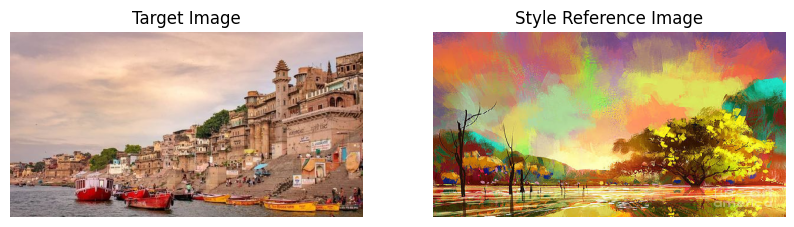

In [3]:
# This is the path to the image you want to transform.
target_image_path = '/kaggle/input/images/banaras.jpg'
# This is the path to the style image.
style_image_path = '/kaggle/input/images/style2.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = height
img_width = int(width * img_height / height)

# Load images
target_image = load_img(target_image_path, target_size=(img_height, img_width))
style_image = load_img(style_image_path, target_size=(img_height, img_width))

# Convert images to arrays
target_array = img_to_array(target_image)
style_array = img_to_array(style_image)

# Display the images using matplotlib
plt.figure(figsize=(10, 5))

# Display target image
plt.subplot(1, 2, 1)
plt.imshow(target_array.astype('uint8'))
plt.title('Target Image')
plt.axis('off')

# Display style reference image
plt.subplot(1, 2, 2)
plt.imshow(style_array.astype('uint8'))
plt.title('Style Reference Image')
plt.axis('off')

# Show the plot
plt.show()


In [4]:
tf.compat.v1.disable_eager_execution()

# Preprocessing and Model Architecture

We will use a pretrained VGG19 model for our task of style transfer.
We'll require some additional functions to handle loading, pre-processing, and post-processing the images that will be input to and output from the VGG19 convolutional neural network.

In [5]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we will configure the pretrained VGG19 model on imagenet weights. For that we have a set of three images: Target Image, Style image and the placeholder for generated image. The Initial two images are static so we use K.constant for them, but the values that are contained in the placeholder will change over the period of training time.




In [6]:
target_image = K.constant(preprocess_image(target_image_path))
style_image = K.constant(preprocess_image(style_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

80134624/80134624 [==============================] - 0s 0us/step
Model loaded.


# Loss Functions

Here, We will define what we aim to achieve i.e adapt the learned style features to new works while maintaining the original content and integrity of the artwork, and to minimise the generated loss. The loss function can be given as:


**Loss = distance(style(artistic_style_image) - style(generated_image)) +
distance(content(original_image) - content(generated_image))**


Here, "distance" represents a norm function like the L2 norm. "Content" is a function that assesses an image and computes its content representation, while "style" is a function that evaluates an image and computes its style representation. Minimizing this loss would lead to the generated image having a style close to that of the referenced style image, and the content of the generated image being similar to the content of the target image.




Now, we will define the loss functions. The first and second losses are content loss and Style loass as defined above. The Third loss function is total variation loss, which is used to avoid overly pixelated results. It basically acts as Regularization loss.
Our aim is to minimize the weighted average of these three losses.

In [7]:
#Content Loss Function
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [8]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# Style Loss Function
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [9]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

Now we will need to define the weights assigned to each loss, where each weight has its significant meaning. The higher *content_weight* will mean that the **generated_image** will be more similar or say recognizable as the **target_image**.

Here we are using one layer for calculating content loss and 5 layers for calculating style losses at each layer, that we can modify according to our needs.

In [10]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.25

# Defining the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features, combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

Next, We will calculate losses and gradients. Computing both losses and grads seperately will increase the execution time, so to overcome that we have defined a class Evaluator() that calculates losses and grads at once, saving us time.

In [11]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


Ultimately, we can execute the gradient ascent process utilizing SciPy's L-BFGS algorithm as given in the Gatys et al paper (reference given in repo), while preserving the current generated image at each iteration. We are going to run it for 400 steps due to less comptuting resources, but one can go upto ant no of steps dependiing on their choice as the loss will be so large initially but goes on decreasing

# Training

In [16]:
result_prefix = 'generated_result'
iterations = 400

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Iteration', i+1)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Loss Value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i

Iteration 1
Loss Value: 1320671500.0
Iteration 2
Loss Value: 704696300.0
Iteration 3
Loss Value: 487940320.0
Iteration 4
Loss Value: 398062100.0
Iteration 5
Loss Value: 337673000.0
Iteration 6
Loss Value: 301282240.0
Iteration 7
Loss Value: 272053540.0
Iteration 8
Loss Value: 251953090.0
Iteration 9
Loss Value: 238157380.0
Iteration 10
Loss Value: 226574560.0
Iteration 11
Loss Value: 214993650.0
Iteration 12
Loss Value: 205936140.0
Iteration 13
Loss Value: 198398500.0
Iteration 14
Loss Value: 190676260.0
Iteration 15
Loss Value: 183297300.0
Iteration 16
Loss Value: 177511840.0
Iteration 17
Loss Value: 172681230.0
Iteration 18
Loss Value: 167912700.0
Iteration 19
Loss Value: 164162640.0
Iteration 20
Loss Value: 160769730.0
Iteration 21
Loss Value: 157565310.0
Iteration 22
Loss Value: 154636320.0
Iteration 23
Loss Value: 152044800.0
Iteration 24
Loss Value: 149699500.0
Iteration 25
Loss Value: 147335300.0
Iteration 26
Loss Value: 145372200.0
Iteration 27
Loss Value: 143562600.0
Iteration

# Results 

In [17]:
save_img(fname, img)
print('Image saved as', fname)

Image saved as generated_result_at_iteration_399.png


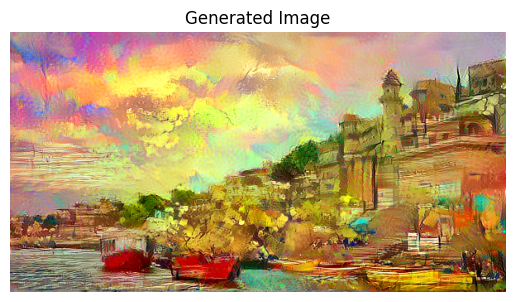

In [18]:
plt.imshow(img)
plt.axis('off')  # Optional: Turn off axis labels
plt.title('Generated Image')
plt.show()

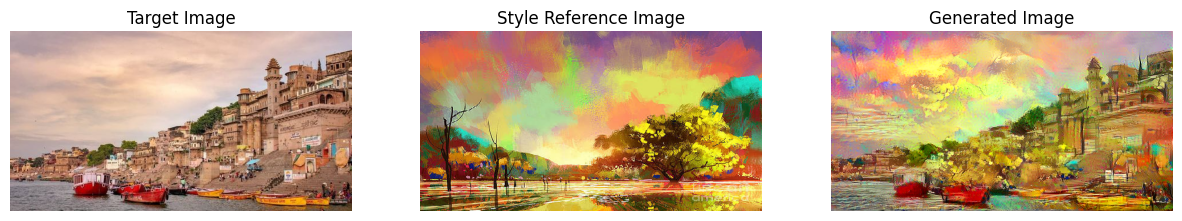

In [19]:
plt.figure(figsize=(15, 7))
# Display target image
plt.subplot(1, 3, 1)
plt.imshow(target_array.astype('uint8'))
plt.title('Target Image')
plt.axis('off')

# Display style reference image
plt.subplot(1, 3, 2)
plt.imshow(style_array.astype('uint8'))
plt.title('Style Reference Image')
plt.axis('off')

#Display Final Output
generated_img_array=img_to_array(img)
plt.subplot(1, 3, 3)
plt.imshow(generated_img_array.astype('uint8'))
plt.title('Generated Image')
plt.axis('off')

# Adjust spacing between subplots
# plt.subplots_adjust(wspace=0.5)

# Show the plot
plt.show()

# Evaluation of the Results

**Structural Similarity Index (SSI)** for content preservation

In [20]:
from skimage import io, color, measure
from skimage.metrics import structural_similarity as ssim

# Load the two images
image1 = io.imread('/kaggle/input/images/banaras.jpg', as_gray=True)
image2 = io.imread('/kaggle/working/generated_result_at_iteration_399.png', as_gray=True)

# Ensure both images have the same shape
min_shape = min(image1.shape, image2.shape)
image1 = image1[:min_shape[0], :min_shape[1]]
image2 = image2[:min_shape[0], :min_shape[1]]

# Convert images to grayscale if they are in color
if len(image1.shape) == 3:
    image1 = color.rgb2gray(image1)
if len(image2.shape) == 3:
    image2 = color.rgb2gray(image2)

# Calculate the Structural Similarity Index (SSI) with data_range specified
ssi_index, _ = ssim(image1, image2, full=True, data_range=image2.max() - image2.min())

# Print the SSI index
print(f"Structural Similarity Index (SSI): {ssi_index}")


Structural Similarity Index (SSI): 0.5128001152969448


The Structural Similarity Index (SSI) of approximately 0.51 suggests a moderate level of structural similarity between the two images. This value ranges from 0 to 1, where **1 indicates perfect similarity**, **0 denotes no similarity**, and **negative values signify dissimilarity**. In this case, the SSI value of 0.51 implies that the structures and content of the two images exhibit some similarity, but noticeable differences are present, likely due to the addition of style over the original image.

To evaluate the **style transfer quality** we can monitor the loss function used during style transfer. **Lower losses indicate better style transfer**. Also, we can use Human feedback in form of MOS scores to gather feedback on whether users find the stylized images aesthetically pleasing and faithful to the intended style or not.